# ISPC phase searc match

Notebook iterating gamma. I use this to generate experimental phases used for the analysis.

### Imports

In [1]:
from XRDXRFutils import (Phase, DatabaseXRD, DataXRF, DataXRD, SpectraXRD, FastSpectraXRD, GaussNewton,
    PhaseList, ChiSearch, GammaMap, ChiMap, Phase, PhaseList, GammaSearch_Secondary, GammaMap_Secondary)

from os.path import isdir
from os import makedirs
from shutil import rmtree

import h5py
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit, least_squares

from numpy import (linspace, concatenate, sqrt, log, sin, pi, histogram, array, unravel_index, savetxt,
    flip, sum, average, amax, arange, empty, newaxis)
import pandas as pd

from matplotlib.pyplot import (sca, show, fill_between, legend, imshow, subplots, plot, xlim, ylim,
    xlabel, ylabel, cm, title, scatter, colorbar, figure, vlines, savefig, get_cmap)
from matplotlib import rcParams
from matplotlib.ticker import FuncFormatter, ScalarFormatter
from matplotlib.markers import MarkerStyle
from matplotlib.colors import BoundaryNorm
from matplotlib.lines import Line2D

from sklearn.cluster import KMeans, MiniBatchKMeans

from multiprocessing import Pool

from glob import glob
from PIL import Image

from pathlib import Path


def f_linear(x,a,b):
    return a*x + b


def f_loss(x,t,y):
    return (x[0]*t + x[1]) - y


def fmt(x, pos):
    a, b = '{:.1e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)


def read_raw_XRD(path_xrd, filename_scanning = 'Scanning_Parameters.txt', filename_calibration = 'calibration.ini', filename_h5 = 'xrd.h5'):
    return (DataXRD().read_params(path_xrd + filename_scanning).read(path_xrd)
            .calibrate_from_file(path_xrd + filename_calibration).remove_background().save_h5(path_xrd + filename_h5))


def correct_point(experimental_phases, idx_phase, gm, x, y):
    gn = gm.get_pixel(x, y)[idx_phase]
    phase = gn.make_phase()
    phase.set_name('created_%d'%idx_phase)
    phase.set_point(gm.get_index(x, y))
    experimental_phases[idx_phase] = phase

    
def rename_phase_in_database(database, name_old, name_new):
    for p in database[name_old]:
        p['_chemical_name_mineral'] = name_new
    database[name_new] = database[name_old]
    del database[name_old]


rcParams.update({
'image.origin': 'lower'
})

# Define paths and parameters

In [2]:
#path_shared = '/home/shared/'
path_shared = '../../shared/'

### Input ###
path_scan = path_shared + 'dataXRDXRF/MunchMuseum/M491/'
path_xrd = path_scan + 'ProfiloXRD/'          # XRD scan 
path_xrf = path_scan + 'ProfiloXRF/labels/'   # XRF scan
path_photo = path_scan + 'ProfiloFoto/'       # photo of the scanned section
path_zmap = path_shared + 'VenereBZPosition/'
path_database = path_shared + 'Database/'     # tabulated phases

### Output ###
subfolder_output = 'MunchMuseum/M491/Profilo/'
path_figures = 'figures/' + subfolder_output          # figures generated by the script
path_results = 'results/' + subfolder_output          # results generated by the script: raw data, tif maps
path_database_exp = 'databaseEXP/' + subfolder_output # experimental phases

### Parameters ###
min_theta = 20
max_theta = 53
min_intensity = 0.1  # among the tabulated peaks, selects only the ones above this threshold of intensity (scale between 0 and 1)
first_n_peaks = None # selects the first n most intense peaks (if None, leaves all the peaks)
sigma = 0.2          # sigma used in the peaks of synthetic diffraction patterns

#### To reset results, delete output folders.
WARNING: every previous result will be lost. Use only if you want to delete all files in the data folders

In [3]:
#if isdir(path_figures):
#    rmtree(path_figures)
#if isdir(path_results):
#    rmtree(path_results)
#if isdir(path_database_exp):
#    rmtree(path_database_exp)

#### Check if output folders exist. If not, create them.

In [4]:
if not isdir(path_figures):
    makedirs(path_figures)
if not isdir(path_results):
    makedirs(path_results)
if not isdir(path_database_exp):
    makedirs(path_database_exp)

# Show photo of scanned section

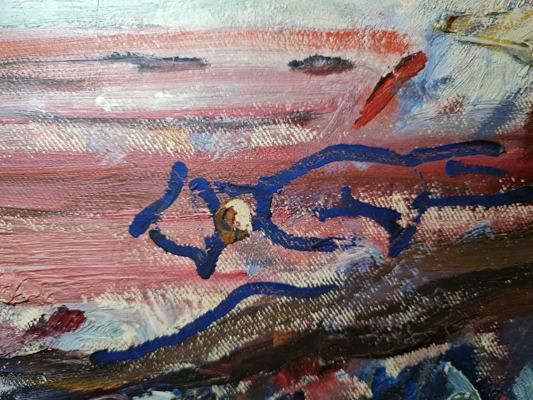

In [5]:
filenames = glob(path_photo + '*.jpg')
for filename in filenames:
    im = Image.open(filename)
    display(im.resize([s // 3 for s in im.size]))

# Read XRD Data and Database
To recalculate h5 file, change just for one time the filename that the cell tries to read (indicated by the comment)

Loading: ../../shared/dataXRDXRF/MunchMuseum/M491/ProfiloXRD/xrd.h5
Shape of data: (95, 170, 1280)
Initial calibration:
a = -1214.7, s = 1952.7, beta = 51.663
Theta range [19.77907407899562, 53.578190550653794]

Phases in database: 352


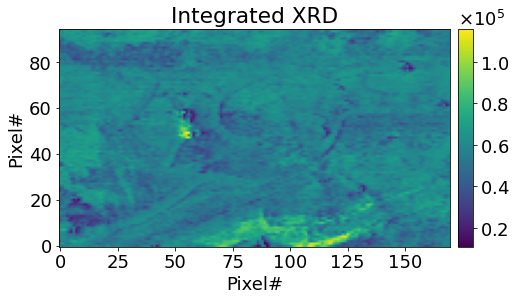

In [6]:
%matplotlib inline
rcParams['font.size'] = 12

try:
    data = DataXRD().load_h5(path_xrd + 'xrd.h5') # to force the recalculation of h5 file, change this filename
    if any(not hasattr(data, attr) for attr in data.check_attributes):
        print('The present h5 file doesn\'t have all required information. Reading from raw data.')
        data = read_raw_XRD(path_xrd)
except:
    print('Reading from raw data.')
    data = read_raw_XRD(path_xrd)
    
print(f'Shape of data: {data.shape}')
print('Initial calibration:')
print(f'a = {data.opt[0]:.1f}, s = {data.opt[1]:.1f}, beta = {data.opt[2]:.3f}')
print(f'Theta range {list(data.fce_calibration([0, data.shape[2]], *data.opt))}')

database = DatabaseXRD().read_cifs(path_database)
print('\nPhases in database:', len(database))

rcParams['font.size'] = 18
fig, ax = subplots(figsize = (7, 5))
im = ax.imshow(data.data.sum(axis=2))
formatter = ScalarFormatter(useMathText = True)
formatter.set_scientific(True)
formatter.set_powerlimits((-2, 3))
cbar = colorbar(im, ax = ax, cax = ax.inset_axes([1.02, 0, 0.04, 1]), format=formatter)
cbar.ax.yaxis.set_offset_position('left')
ax.set_title('Integrated XRD')
ax.set_xlabel(r'Pixel#')
ax.set_ylabel(r'Pixel#')
savefig(path_figures + 'TotalDiffractionImage.png')
show()

### Correct burnt pixel
Selects the pixel with the maximum value and substitutes all its channel with a constant lower value

In [7]:
# array_max = data.data.max(axis=2)
# print(array_max.argmax())
# idx = unravel_index(array_max.argmax(), array_max.shape)
# print(idx)
# data.data[idx] = array_max.min()

### Show aggregated information about XRD data

We process raw XRD data by subtracting the background (obtained by SNIP).
On this data we calculate aggregated information.

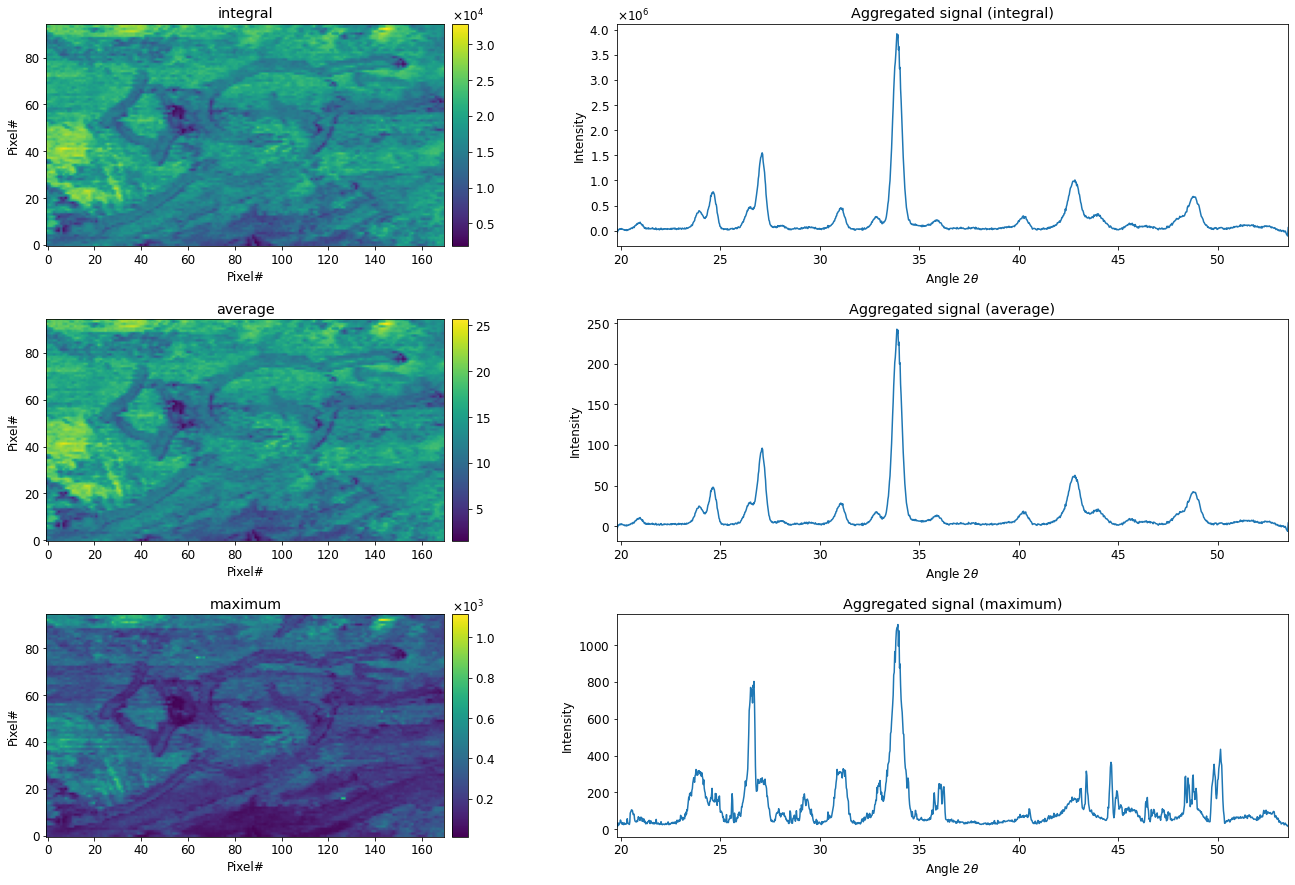

In [9]:
rcParams['font.size'] = 12

fig, axs = subplots(3, 2, figsize = (20, 12))
fig.tight_layout(h_pad = 4, w_pad = 0)

theta = data.fce_calibration(range(data.shape[-1]), *data.opt)
list_aggregations = ['integral', 'average', 'maximum']
list_functions = [sum, average, amax]
data_to_process = data.data - data.background

for i in range(len(list_aggregations)):

    image_aggregated = list_functions[i](data_to_process, axis = 2)
    ax = axs[i, 0]
    im = ax.imshow(image_aggregated)
    formatter = ScalarFormatter(useMathText = True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-2, 3))
    cb = colorbar(im, ax = ax, cax = ax.inset_axes([1.02,0, 0.04, 1]), format = formatter)
    cb.ax.yaxis.set_offset_position('left')
    ax.set_title(list_aggregations[i])
    ax.set_ylabel(r'Pixel#')
    ax.set_xlabel(r'Pixel#')

    xrdpattern_aggregated = list_functions[i](data_to_process.reshape((-1, data_to_process.shape[-1])), axis = 0)
    ax = axs[i, 1]
    ax.plot(theta, xrdpattern_aggregated)
    ax.ticklabel_format(useMathText = True)
    ax.set_xlim(theta[0], theta[-1])
    ax.set_xlabel(r'Angle $2\theta$')
    ax.set_ylabel('Intensity')
    ax.set_title(f'Aggregated signal ({list_aggregations[i]})')

savefig(f'{path_figures}aggregated_info.png', bbox_inches = 'tight', dpi = 300)
show()

### Show rescaling and signal / background ratio

- 'Rescaling' shows, for each pixel, the maximum value of the experimental diffraction pattern after we subtract the background.
This value is used to obtain the rescaled signal in the interval [0, 1].
That's why we indicate this value as 'rescaling'.

- 'Signal/Noise' indicates the integral of the experimental diffraction pattern divided by the integral of the background.

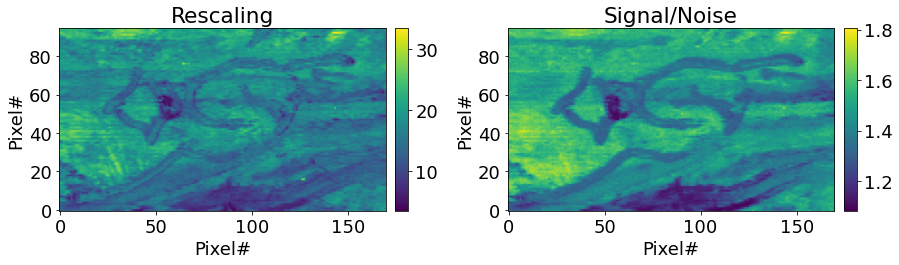

In [21]:
from numpy import log

rcParams['font.size'] = 18

fig, axs = subplots(1, 2, figsize = (12, 6))
fig.tight_layout(w_pad = 4)

ax = axs[0]
im = ax.imshow(data.rescaling.squeeze()**0.5)
cbar = colorbar(im, ax = ax, cax = ax.inset_axes([1.03, 0, 0.04, 1]))
ax.set_title('Rescaling')
ax.set_ylabel(r'Pixel#')
ax.set_xlabel(r'Pixel#')

ax = axs[1]
im = ax.imshow(data.signal_background_ratio.squeeze())
cbar = colorbar(im, ax = ax, cax = ax.inset_axes([1.03, 0, 0.04, 1]))
ax.set_title('Signal/Noise')
ax.set_ylabel(r'Pixel#')
ax.set_xlabel(r'Pixel#')

show()

# Read z position and laser correction

In [22]:
list_z = []
list_laser = []

filenames = sorted(glob(path_zmap + '/*.txt'))
for filename in filenames:
    df = pd.read_csv(filename, sep = '\s+')
    list_z.append(df['Z'].values)
    list_laser.append(df['Laser'].values)

matrix_z = array(list_z)
matrix_laser = array(list_laser)
matrix_sum_z_laser = matrix_z + matrix_laser

### Show maps

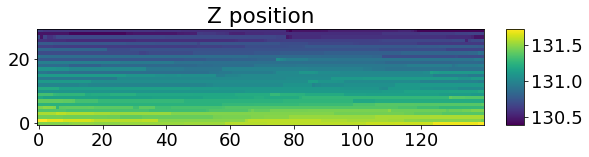

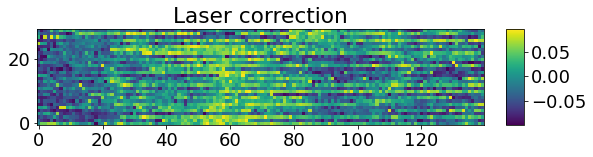

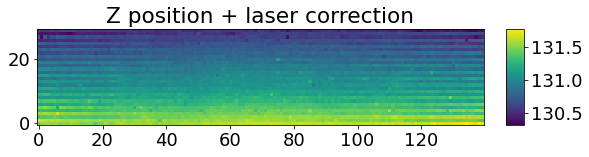

In [23]:
rcParams['font.size'] = 18

fig, ax  = subplots(figsize = (8, 6))
im = ax.imshow(matrix_z)
colorbar(im, ax = ax, cax = ax.inset_axes([1.05, 0, 0.04, 1]))
ax.set_title('Z position')
show()

fig, ax  = subplots(figsize = (8, 6))
im = ax.imshow(matrix_laser)
colorbar(im, ax = ax, cax = ax.inset_axes([1.05, 0, 0.04, 1]))
ax.set_title('Laser correction')
show()

fig, ax  = subplots(figsize = (8, 6))
im = ax.imshow(matrix_sum_z_laser)
colorbar(im, ax = ax, cax = ax.inset_axes([1.05, 0, 0.04, 1]))
ax.set_title('Z position + laser correction')
show()

# Read XRF images

If the orientation of tiff images does not correspond with XRD scans, flip them in this cell

In [24]:
data_xrf = DataXRF()
data_xrf.read_tiff(path_xrf)
data_xrf.labels = flip(data_xrf.labels, axis = [1]) # choose the axes to flip
print(f'Found {data_xrf.labels.shape[2]} images')

Found 24 images


### Show XRF images

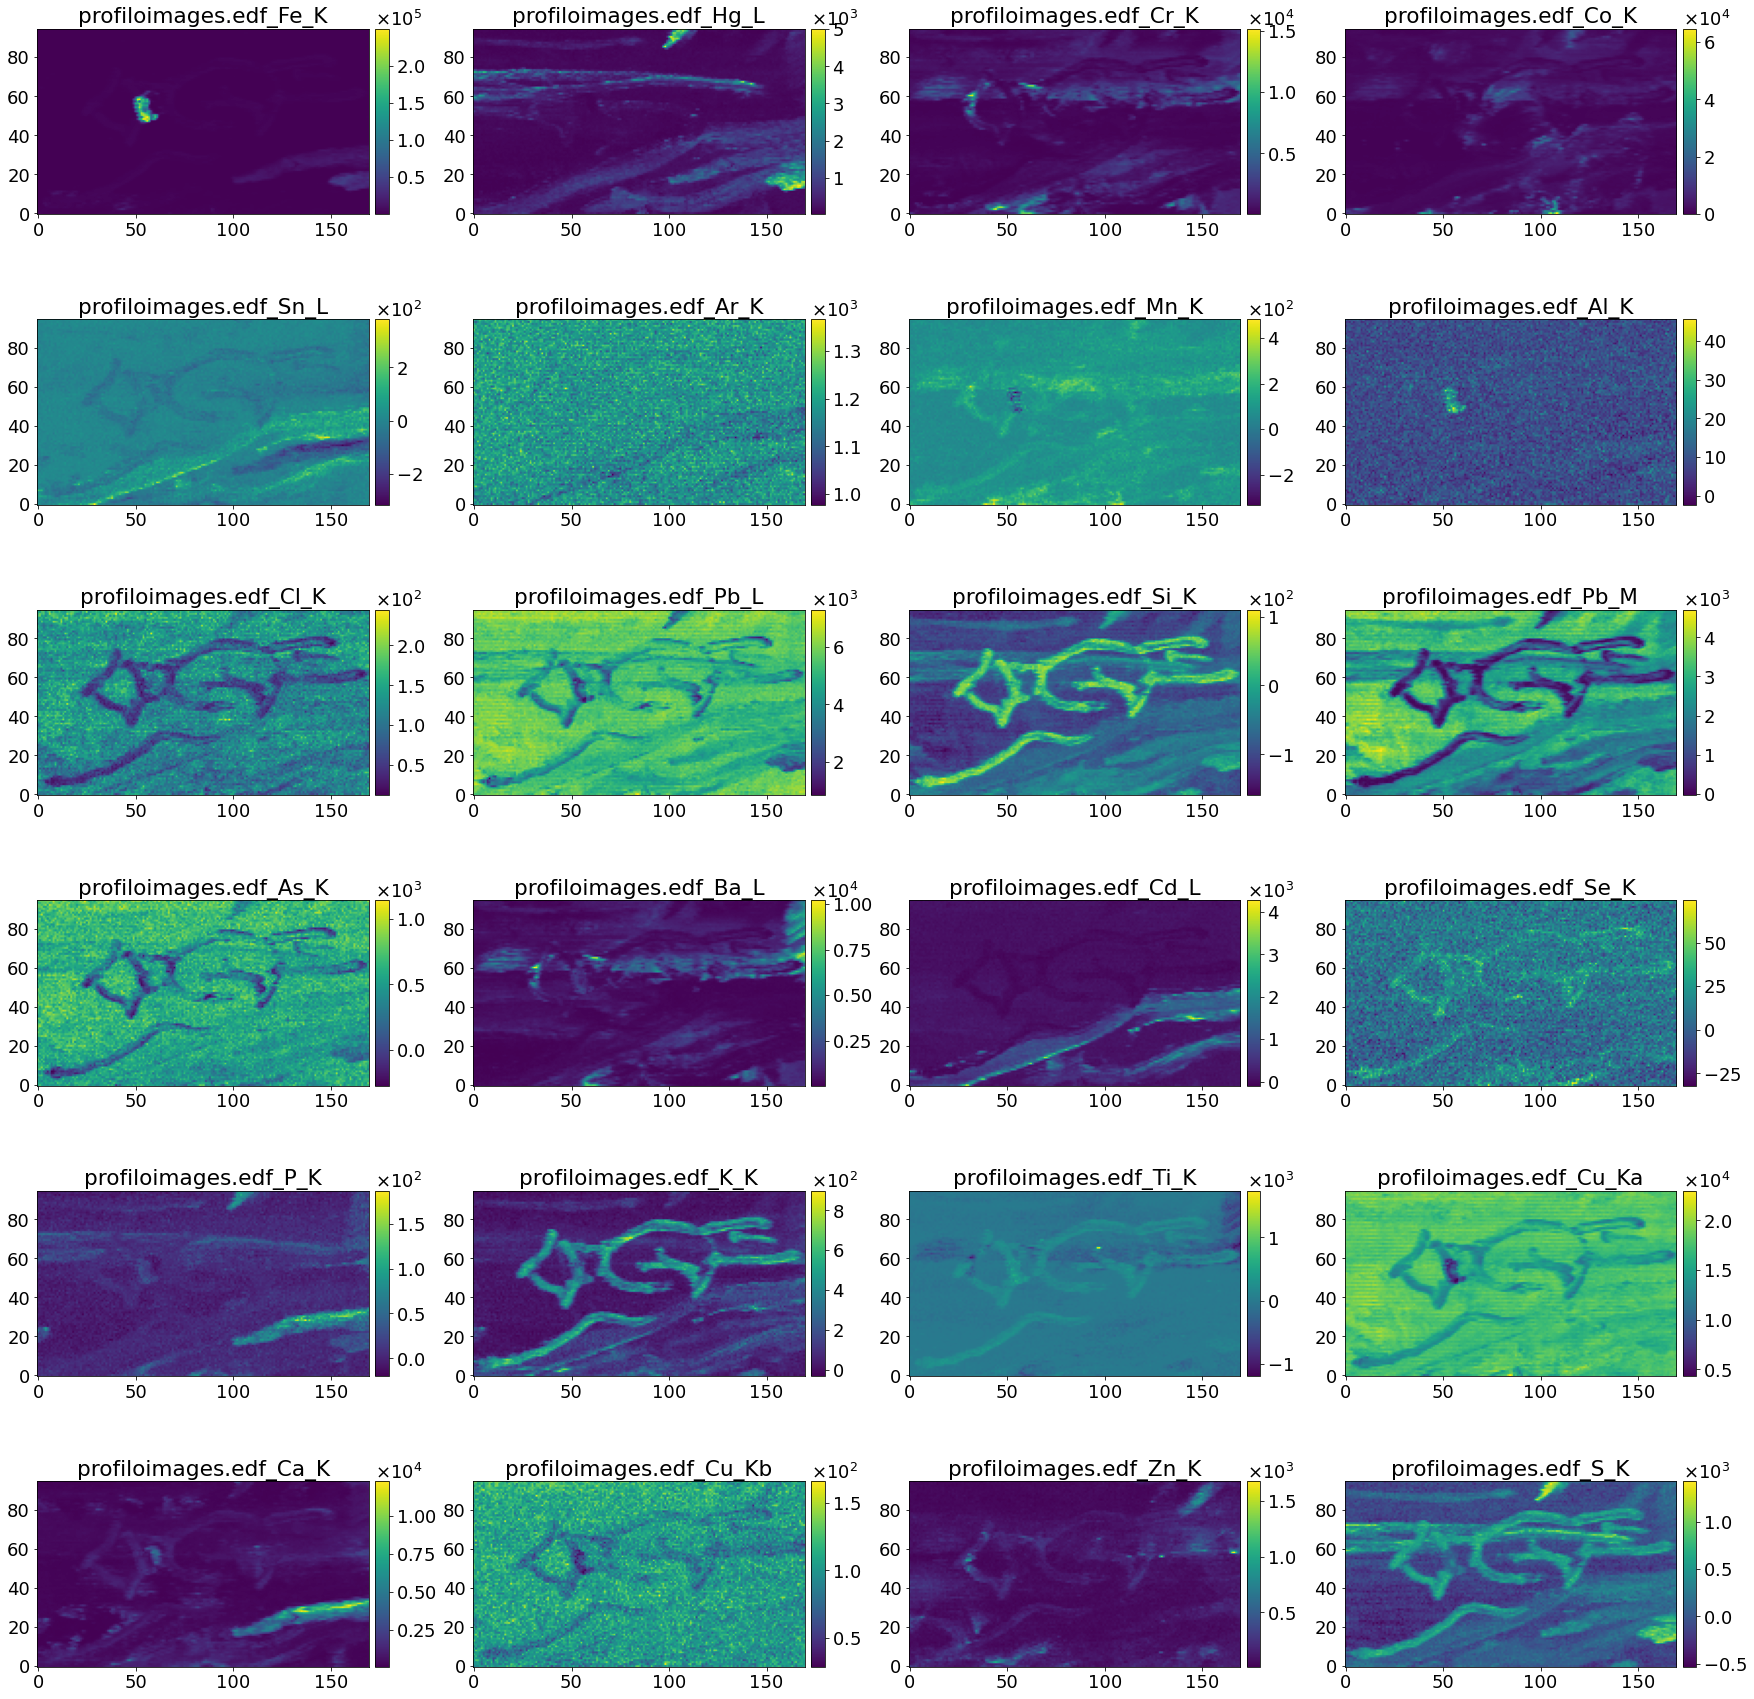

In [25]:
#%matplotlib qt
%matplotlib inline
n_of_columns = 4
rcParams['font.size'] = 18

n_of_pictures = len(data_xrf.metadata['labels'])
n_of_rows = n_of_pictures // n_of_columns
if (n_of_pictures % n_of_columns):
    n_of_rows += 1

fig, axs = subplots(n_of_rows, n_of_columns, figsize = (6 * n_of_columns, 4 * n_of_rows))
fig.tight_layout(h_pad = 3, w_pad = 3)
for i, label in enumerate(data_xrf.metadata['labels']):
    i_row = i // n_of_columns
    i_column = i % n_of_columns
    if n_of_rows == 1:
        ax = axs[i_column]
    else:
        ax = axs[i_row, i_column]
    im = ax.imshow(data_xrf.labels[..., i])
    formatter = ScalarFormatter(useMathText = True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-2, 2))
    cb = colorbar(im, ax = ax, cax = ax.inset_axes([1.02, 0, 0.04, 1]), format = formatter)
    cb.ax.yaxis.set_offset_position('left')
    ax.set_title(label)
show()

## Define phases

This is for simplification. Phases can be selected iteratively from database using 'Tab'

In [26]:
rename_phase_in_database(database, 'Cr O4 Sr', 'Strontium chromate')
rename_phase_in_database(database, 'Pb (Cr O4)', 'Chrome yellow')

In [27]:
### COLOURS AND SECONDARY PHASES ###

# Blue
lazurite = database['Lazurite'][0]
prussian_blue = database['Prussian_Blue'][0]
ultramarine_blue_dark = database['Ultramarine_blue_dark'][0]
ultramarine_blue_very_dark = database['Ultramarine_blue_very_dark'][0]
cobalt_blue_pale = database['Cobalt_blue_pale'][0]
cobalt_blue_dark = database['Cobalt_blue_dark'][0]
indigo = database['Indigo_blue_lake'][0]
alum_k = database['Alum-K'][0]

phases_secondary_blue = [prussian_blue, ultramarine_blue_dark, ultramarine_blue_very_dark, cobalt_blue_pale, cobalt_blue_dark, indigo, alum_k]


# Green
viridian = database['Viridian_green'][0]
phthalo_green_dark = database['Phthalo_green_dark'][0]
verdigris = database['Verdigris_synthetic'][0]
malachite = database['Malachite_natural_standard'][0] # 0, 1

phases_secondary_green = [viridian, phthalo_green_dark, verdigris, malachite]


# Yellow / orange
strontium_chromate = database['Strontium chromate'][0]
chrome_yellow = database['Chrome yellow'][0]
crocoite = database['Crocoite'][0]
Cd_S_orange = database['Cadmium sulfoselenide orange'][0]
cobalt_yellow = database['Cobalt_yellow'][0]
goethite = database['Goethite'][0]

phases_secondary_yellow = [strontium_chromate, chrome_yellow, crocoite, Cd_S_orange, cobalt_yellow, goethite]


# Red
cinnabar = database['Cinnabar'][1]
sienna = database['Burnt_Sienna_Italian'][0]
Cd_S_red = database['Cadmium sulfoselenide red'][0]
hematite = database['Hematite'][4]
madder_lake = database['Madder_Lake_genuine'][0]
alizarine = database['Alizarine_crimson_dark'][0]

phases_secondary_red = [sienna, Cd_S_red, hematite, madder_lake, alizarine]


# Black
bone_black = database['Bone_Black'][0]
caput_mortuum = database['Caput_Mortuum_violet'][0]

phases_secondary_black = [bone_black, caput_mortuum]


# White
hydrocerussite = database['Hydrocerussite'][0]
zinc_white = database['Zinc_white'][0]
barite = database['Barite'][0]

phases_secondary_white = [zinc_white, barite]


# Purple/violet
cobalt_phosphate = database['Cobalt phosphate'][0]
manganese_violet = database['Manganese_violet'][0]
cobalt_arsenate = database['Tricobalt arsenate(V) - HT'][0] #As2 Co3 O8

phases_secondary_violet = [cobalt_phosphate, manganese_violet, cobalt_arsenate]



### PRIMARY PHASES ###
phases_primary = [hydrocerussite, lazurite, cinnabar]

### Explore phase database

See the phases in the database that contain all of the chosen elements.

In [28]:
elements_chosen = ['Cd', 'Zn']

list_name = []
list_formula = []
list_number = []
for k, v in sorted(database.items()):
    p = v[0]
    if '_chemical_formula_sum' in p:
        if all(e in p['_chemical_formula_sum'] for e in elements_chosen):
            list_name.append(k)
            list_formula.append(p['_chemical_formula_sum'])
            list_number.append(len(v))

pd.DataFrame(
    columns = ['Name in database', 'Chemical formula', 'Number of samples'],
    data = array([list_name, list_formula, list_number]).T
)#.iloc[0:3] # if there are too many lines, change this to select the lines you see

Name in database Chemical formula Number of samples
0  Cadmium zinc sulphide yellow          Cd Zn S                 5

### Plot XRF map of selected element

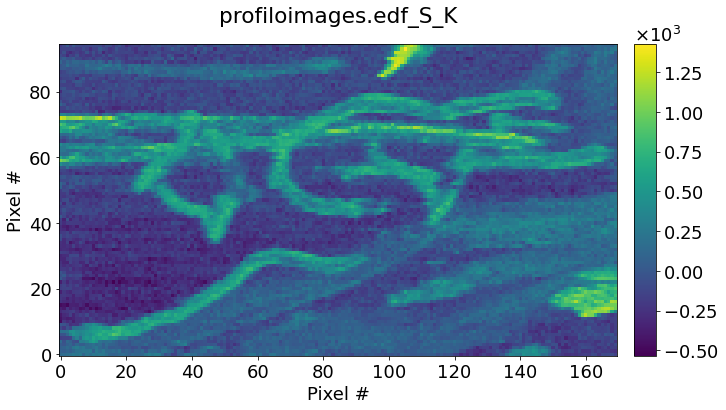

In [29]:
%matplotlib inline
#%matplotlib qt
rcParams['font.size'] = 18

element_chosen = 'S'

for i, label in enumerate(data_xrf.metadata['labels']):
    #if element_chosen in label:   # search for the given string in XRF label
    if (element_chosen + '_') in label:   # search for the given string + '_' in XRF label
        fig, ax = subplots(figsize = (10, 7))
        im = ax.imshow(data_xrf.labels[..., i],
                       vmin = None, vmax = None) # TO CHANGE SCALE: set vmin and vmax, otherwise leave them as None
        formatter = ScalarFormatter(useMathText = True)
        formatter.set_scientific(True)
        formatter.set_powerlimits((-2, 2))
        cb = colorbar(im, ax = ax, cax = ax.inset_axes([1.03, 0, 0.04, 1]), format = formatter)
        cb.ax.yaxis.set_offset_position('left')
        ax.set_title(label, y = 1.05)
        ax.set_xlabel('Pixel #')
        ax.set_ylabel('Pixel #')
    
show()

### Plot 3 XRF maps as 1 RGB map

Cd:	profiloimages.edf_Cd_L
Zn:	profiloimages.edf_Zn_K
S:	profiloimages.edf_S_K


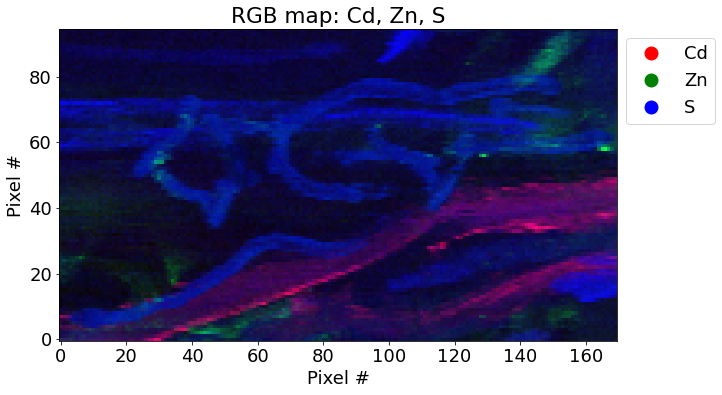

In [36]:
rcParams['font.size'] = 18
elements_chosen = ['Cd', 'Zn', 'S']
factors_intensity = [1, 1, 1]

check_find = [False] * 3
image_rgb = empty(list(data_xrf.labels.shape[:2]) + [3])
for i, elem in enumerate(elements_chosen):
    for j, label in enumerate(data_xrf.metadata['labels']):
        #if elem in label:   # search for the given string in XRF label
        if (elem + '_') in label:   # search for the given string + '_' in XRF label
            print(elem + ':\t' + label)
            check_find[i] = True
            image_rgb[..., i] = data_xrf.labels[..., j]
    if not check_find[i]:
        print(elem + ' not found.')

if all(check_find):
    image_rgb -= image_rgb.min(axis = (0, 1), keepdims = True)
    image_rgb /= image_rgb.max(axis = (0, 1), keepdims = True)
    image_rgb *= array(factors_intensity)[newaxis, newaxis, :]
    image_rgb /= image_rgb.max()

    fig, ax = subplots(figsize = (10, 7))
    im = ax.imshow(image_rgb)
    legend_elements = [
        Line2D([0], [0], marker = 'o', color = 'w', markerfacecolor = c, markersize = 15, label = elements_chosen[i])
            for i, c in enumerate(['r', 'g', 'b'])
    ]
    ax.legend(handles = legend_elements, bbox_to_anchor=(1,1), loc="upper left")
    ax.set_title('RGB map: ' + ', '.join(elements_chosen))
    ax.set_xlabel('Pixel #')
    ax.set_ylabel('Pixel #')

    show()

### Check phases in a given point

Hydrocerussite (C H O4 Pb1.5)


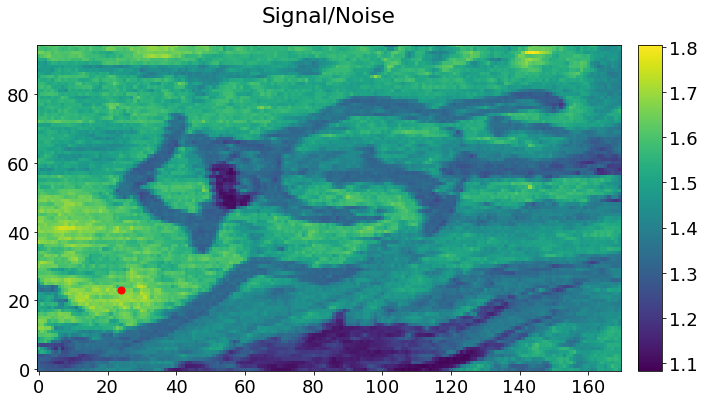

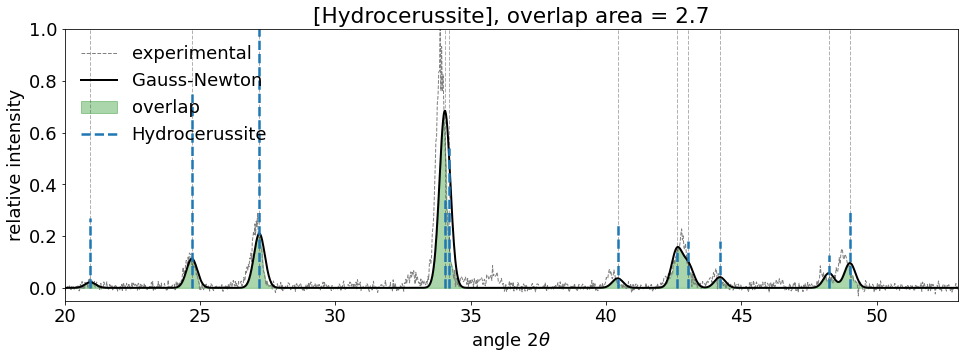

In [37]:
%matplotlib inline
x, y = 24, 23
rcParams['font.size'] = 18

fig, ax = subplots(figsize = (15, 6))
im = ax.imshow(data.signal_background_ratio.squeeze())
ax.scatter(x, y, s = 50, c = 'red', marker = 'o')
cbar = colorbar(im, ax = ax, cax = ax.inset_axes([1.03, 0, 0.04, 1]))
ax.set_title('Signal/Noise', y=1.05)

phases_new = PhaseList([hydrocerussite])

for p in phases_new:
    print(p.label, end = '')
    if '_chemical_formula_sum' in p:
        print (' (' + p['_chemical_formula_sum'] + ')')

gn = GaussNewton(phases_new, FastSpectraXRD().from_Data(data, x, y), min_theta = min_theta, max_theta = max_theta,
    min_intensity = min_intensity, first_n_peaks = first_n_peaks, sigma = sigma)

### Leaves initial calibration and only optimizes the heights of the peaks ###
gn.fit_cycle(gamma = True, steps = 16)

### Optimizes calibration and heights of the peaks ###
#gn.fit_cycle(gamma = True, steps = 16).fit_cycle(a = True, s = True, gamma = True, steps = 16).fit_cycle(gamma = True, steps = 16)

fig, ax = subplots(figsize = (16, 5))
sca(ax)
gn.plot_spectrum(c = 'grey', ls = '--', lw = 1, label = 'experimental')
gn.plot(c = 'black', ls = '-', lw = 2, label = 'Gauss-Newton')
fill_between(gn.theta.squeeze(), gn.overlap(), color = 'g', alpha = 0.33, label = 'overlap')
gn.phase.plot(color = 'k', lw = 1, lineheight = 1, alpha = 0.3, label = '')
gn.phase.plot(lw = 2.5, alpha = 1)
ax.set_xlim(min_theta, max_theta)
ax.set_ylim(-0.05, 1)
ax.set_xlabel(r'angle $2\theta$')
ax.set_ylabel(r'relative intensity')
ax.set_title(f'{gn.label}, overlap area = {gn.overlap3_area():.1f}')
legend(frameon = False, loc = 2)
show()

# Search for primary phases

Adjust initial calibration. This can be executed after the first fit finds a better initial calibration.

### Change initial calibration

In [30]:
# opt_calibration_ini = data.opt
# print('Calibration parameters from calibration.ini:', opt_calibration_ini)
# data.opt = array([-1164.78443104,  2041.65595205,    50.71024209])

In [64]:
if 'pmax_a' in locals():
    data.opt[0] = pmax_a
    data.opt[1] = pmax_s

### Create data structure

In [65]:
#phases_primary = [hydrocerussite, lazurite, cinnabar, barite]

In [66]:
gm = GammaMap().from_data(data, phases_primary, sigma = sigma, min_theta = min_theta, max_theta = max_theta,
    min_intensity = min_intensity, first_n_peaks = first_n_peaks)

### Autocalibration and search
Optimizes on $a,s$ and $\gamma$. Choses the best phase by overlap area and fits with respect to that.

In [67]:
%%time
gm = gm.search()
L1loss, MSEloss, overlap_area = gm.metrics()

Using 8 CPUs
Using 8 CPUs
CPU times: user 11.5 s, sys: 1.65 s, total: 13.1 s
Wall time: 20.6 s


#### Fast mapping

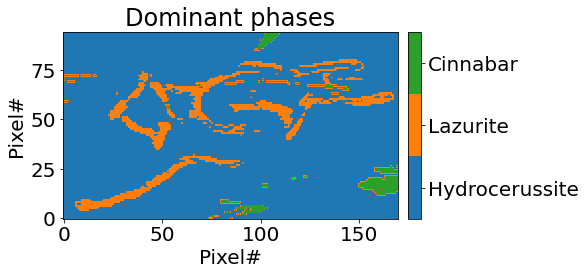

In [68]:
%matplotlib inline
rcParams['font.size'] = 20

fig, ax = subplots(figsize = (6, 6))
cmap_chosen = get_cmap('tab10')
norm_chosen = BoundaryNorm(arange(-0.5, len(phases_primary) + 0.5, 1), len(phases_primary))
im = imshow(gm.selected(), cmap = cmap_chosen, norm = norm_chosen)
cbar = colorbar(im, ax = ax, cax = ax.inset_axes([1.03, 0, 0.04, 1]))
cbar.set_ticks(range(0, len(phases_primary)))
cbar.set_ticklabels([p.label for p in phases_primary])
ax.set_title('Dominant phases')
ax.set_xlabel(r'Pixel#')
ax.set_ylabel(r'Pixel#')

savefig(path_figures + 'fast_map_dominant_phases.png', bbox_inches = 'tight', dpi = 200)
show()

### Histogram of $a$

If $a$ is spead over too large area it means that fitting went wrong. Maybe we need to add phases.

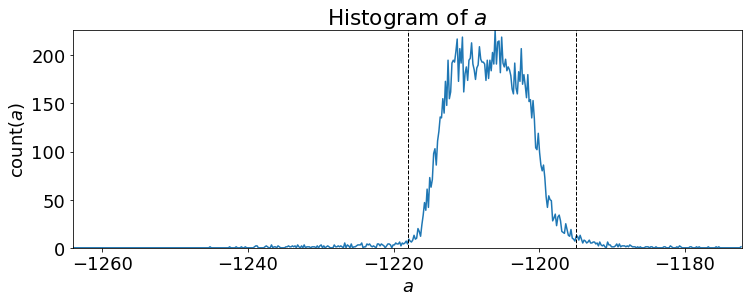

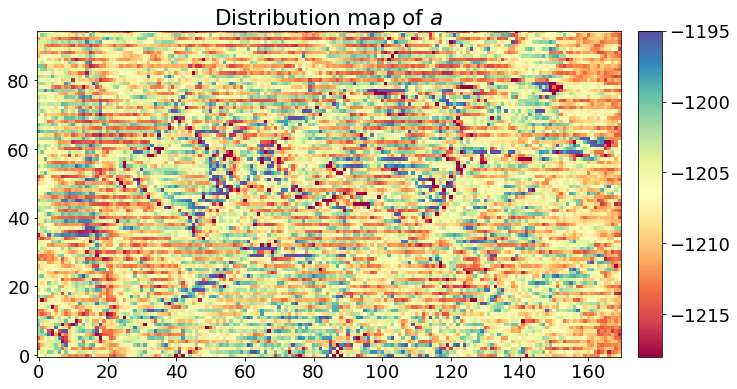

In [69]:
%matplotlib inline
rcParams['font.size'] = 18

opt = gm.opt()
a = opt[..., 0]
s = opt[..., 1]

### Set them for better representation of color map ###
vmin = -1218
vmax = -1195

h, b = histogram(a, bins = 512)

fig, ax = subplots(figsize = (12, 4))
ax.plot(b[:-1], h)
ax.set_xlim(b[0], b[-1])
#ax.set_xlim(-1230, -1180) # TO CHANGE HORIZONTAL SCALE: set these value, otherwise leave this line commented
ax.set_ylim(0, h.max())
ax.vlines(vmin, 0, h.max(), 'k', ls = '--', lw = 1)
ax.vlines(vmax, 0, h.max(), 'k', ls = '--', lw = 1)
ax.set_xlabel('$a$')
ax.set_ylabel(r'count($a$)')
ax.set_title(r'Histogram of $a$')
savefig(path_figures + f'histogram_a_ROI({vmin},{vmax}).png')

fig, ax = subplots(figsize = (12, 6))
ax.set_title('Distribution map of $a$')
im = ax.imshow(a, cmap = 'Spectral', vmin = vmin, vmax = vmax)
colorbar(im, ax = ax, cax = ax.inset_axes([1.03, 0, 0.04, 1]))
savefig(path_figures + f'distribution_map_a_ROI({vmin},{vmax}).png')

show()

## Plotting the $a,s$ dependence

There is a slight notion of a second $a, s$ dependence but it is weak.

Linear: [ -1.6367067  -27.64273031]
Cauchy: [ -0.91126283 847.23165725]
mean a,s: -1206.9381184631225 1947.7609700402388
most probable a,s: -1206.0617647111917 1946.2709136639432


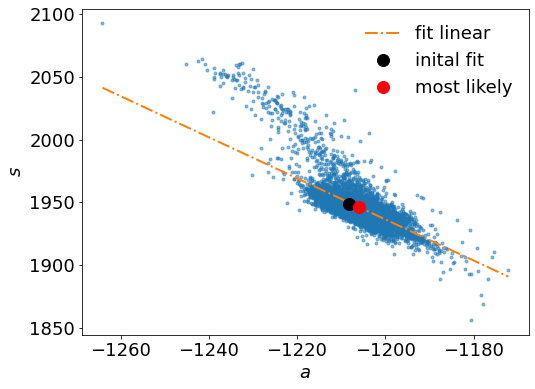

In [70]:
%matplotlib inline
rcParams['font.size'] = 18

opt, var = curve_fit(f_linear, a.flatten(), s.flatten())
res = least_squares(f_loss, x0 = opt, args = (a.flatten(), s.flatten()), loss = 'cauchy')
pmax_a = b[h.argmax()]
pmax_s = f_linear(pmax_a, *res['x'])
x = linspace(a.min(), a.max(), 10)
# linear_y = f_linear(a.flatten(), *opt)
# cauchy_y = f_linear(a.flatten(), *res['x'])

print('Linear:', opt)
print('Cauchy:', res['x'])
print('mean a,s:', a.mean(), s.mean())
print('most probable a,s:', pmax_a, pmax_s)

fig, ax = subplots(figsize = (8, 6))
ax.plot(a.flatten(), s.flatten(), '.', alpha = 0.5)
ax.plot(x, f_linear(x, *opt), '-.', lw = 2, label = 'fit linear')
#ax.plot(x, f_linear(x, *res['x']), '--', lw = 2, label = 'fit cauchy')
ax.plot(data.opt[0], data.opt[1], 'ko', ms = 12, label = 'inital fit')
ax.plot(pmax_a, pmax_s, 'ro', ms = 12, label = 'most likely')
legend(frameon = False)
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$s$')

### TO SET HORIZONTAL AND VERTICAL SCALE ###
# If you prefer automatic scale, you can leave this options commented.
#ax.set_xlim(-1250, -1180)
#ax.set_ylim(1850, 2000)

savefig(path_figures + 'fit_a_s.png')
show()

### Quantify phase presence

In [85]:
correction = data.rescaling**0.5
#correction = data.signal_background_ratio

criterion = overlap_area * correction

### Criterion

Criterion for phase selection.

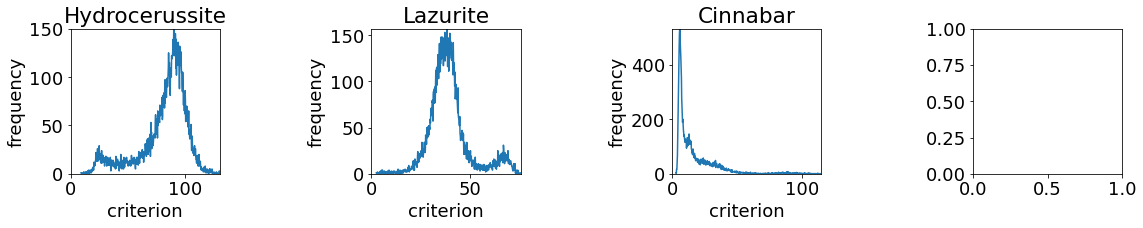

In [86]:
%matplotlib inline
n_of_columns = 4
rcParams['font.size'] = 18

n_of_pictures = len(gm.phases)
n_of_rows = n_of_pictures // n_of_columns
if (n_of_pictures % n_of_columns):
    n_of_rows += 1

fig, axs = subplots(n_of_rows, n_of_columns, figsize = (4 * n_of_columns, 3 * n_of_rows))
fig.tight_layout(h_pad = 5, w_pad = 5)
for i, phase in enumerate(gm.phases):
    i_row = i // n_of_columns
    i_column = i % n_of_columns
    if n_of_rows == 1:
        ax = axs[i_column]
    else:
        ax = axs[i_row, i_column]
    h, b = histogram(criterion[:, :, i], bins = 512)
    ax.plot(b[:-1], h)
    ax.set_xlim(0, b.max())
    ax.set_ylim(0, h.max())
    ax.set_xlabel('criterion')
    ax.set_ylabel('frequency')
    ax.set_title(phase.label)
show()

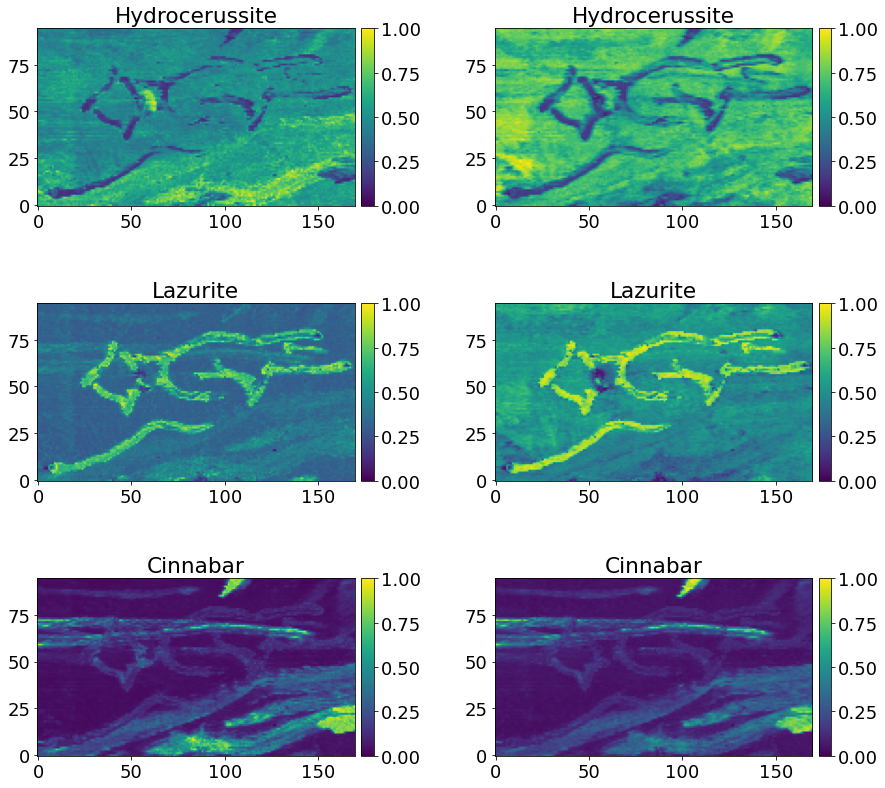

In [87]:
%matplotlib inline
rcParams['font.size'] = 18

fig, axs = subplots(len(gm.phases), 2, figsize = (12, 4 * len(gm.phases)))
fig.tight_layout(h_pad = 0, w_pad = 5)

for i, phase in enumerate(gm.phases):
    ax = axs[i, 0]
    ax.set_title(phase.label)
    matrix_plot = overlap_area[..., i].copy()
    matrix_plot /= matrix_plot.max()
    im = ax.imshow(matrix_plot, vmin = 0)
    colorbar(im, ax = ax, cax = ax.inset_axes([1.02, 0, 0.04, 1]))

    ax = axs[i, 1]
    ax.set_title(phase.label)
    matrix_plot = criterion[..., i].copy()
    matrix_plot /= matrix_plot.max()
    im = ax.imshow(matrix_plot, vmin = 0)
    colorbar(im, ax = ax, cax = ax.inset_axes([1.02, 0, 0.04, 1]))

show()

Select a pixel for each phase based on 'criterion'

In [88]:
experimental_phases = gm.select_phases(criterion, -5)

### Show each phase from its selected pixel

Hydrocerussite (18, 21) 3588 [-1201.48256675  1941.88187126    51.66346438]
Lazurite (39, 72) 12279 [-1209.67152037  1940.85593589    51.66346438]
Cinnabar (104, 89) 15234 [-1202.7719484   1944.05371657    51.66346438]


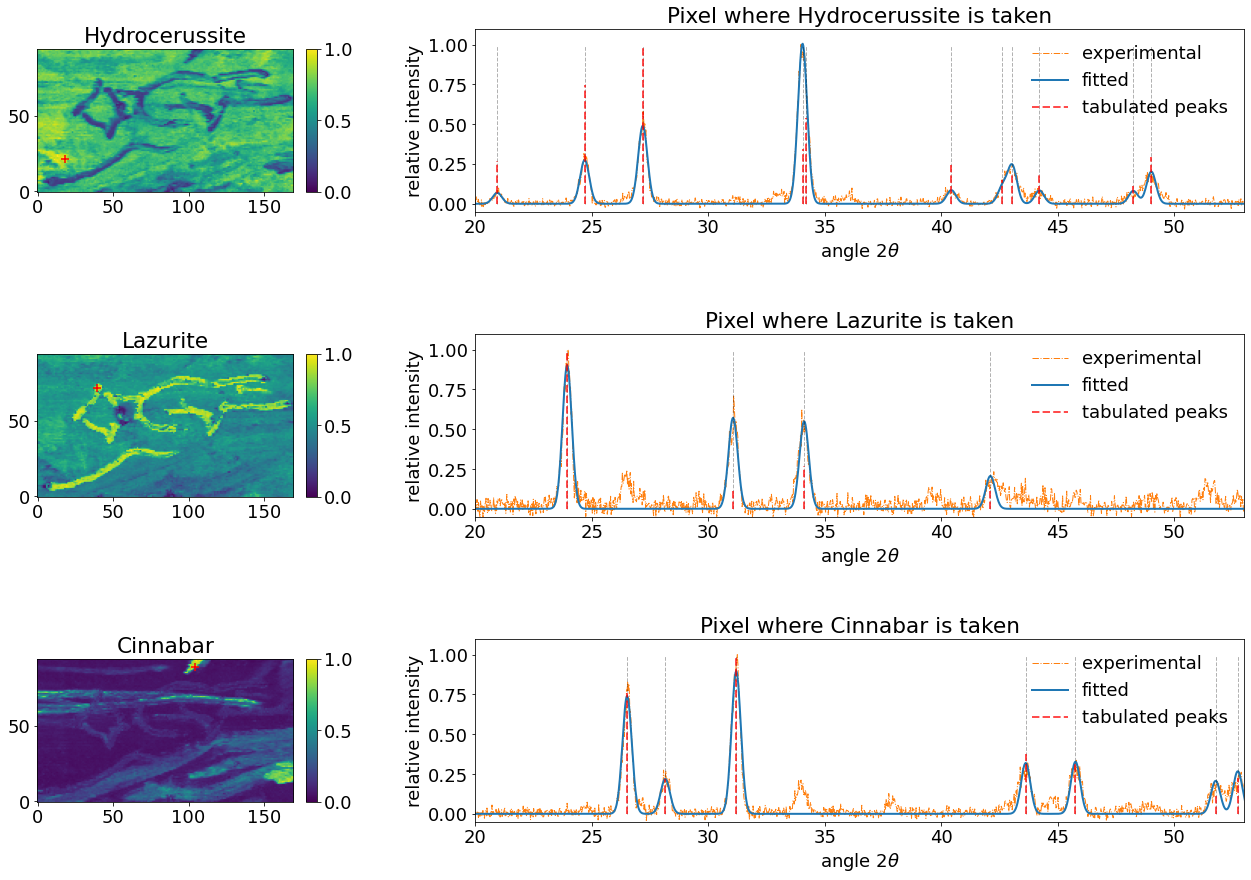

In [89]:
rcParams['font.size'] = 18

#matrix_plot = overlap_area.copy()
matrix_plot = criterion.copy()
matrix_plot /= matrix_plot.max(axis = 0, keepdims = True).max(axis = 1, keepdims = True)

fig, axs = subplots(len(gm.phases), 2, figsize = (18, 4*len(gm.phases)),
                   gridspec_kw = {'width_ratios': [1, 3]})
fig.tight_layout(h_pad = 5, w_pad = 7)

for i, phase in enumerate(experimental_phases):

    if type(phase) == Phase:
        point = phase['point']
    else:
        point = phase[0]['point']
    x, y = gm.get_x_y(point)
    g = gm[point][i]

    if (len(experimental_phases) > 1):
        ax = axs[i, 0]
    else:
        ax = axs[0]
    sca(ax)
    im = imshow(matrix_plot[..., i], vmin = 0)
    cbar = colorbar(im, ax = ax, cax = ax.inset_axes([1.05, 0, 0.04, 1]))
    #cbar.set_label('overlap')
    scatter(x, y, s = 50, c = 'red', marker = '+')
    ax.set_title(phase.label)

    if (len(experimental_phases) > 1):
        ax = axs[i, 1]
    else:
        ax = axs[1]
    sca(ax)
    #g.fit_cycle(gamma = True, steps = 128,a=True,s=True)
    print(g.label, (x, y), point, g.opt)
    g.plot_spectrum(c = 'tab:orange', ls = '-.', lw = 1, label = 'experimental')
    g.plot(c = 'tab:blue', ls = '-', lw = 2, label = 'fitted')
    g.phase.plot(color = 'k', lw = 1, lineheight = 1, alpha = 0.3, label = '')
    g.phase.plot(color = 'r', lw = 2, alpha = 0.7, label = 'tabulated peaks')
    ax.set_xlim(min_theta, max_theta)
    ax.set_ylim(-0.05, 1.1)
    ax.set_xlabel(r'angle $2\theta$')
    ax.set_ylabel(r'relative intensity')
    ax.set_title(f'Pixel where {phase.label} is taken')
    legend(frameon=False)

    spectrum_to_save = array((g.spectrum.counts, g.spectrum.intensity)).T
    savetxt(f'{path_results}Point ({x}, {y}) - selection for {phase.label} - raw counts and intensity.dat', spectrum_to_save, fmt = ['%d', '%.4f'])

savefig(f'{path_figures}pixel selection for each phase.png', bbox_inches = 'tight', dpi = 300)
show()

### Select the phase and correct the point where it is taken

In [131]:
idx_phase = 0
print(f'Selected {experimental_phases[idx_phase].label} among {len(experimental_phases)} phases.')

Selected Hydrocerussite among 2 phases.


In [132]:
correct_point(experimental_phases, 4, gm, 10, 150)
#correct_point(experimental_phases, 5, gm, 145, 34)

ValueError: invalid entry in coordinates array

### Save maps as PNG

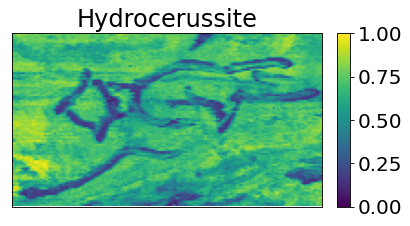

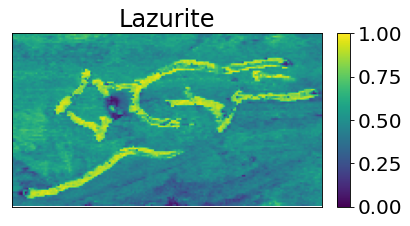

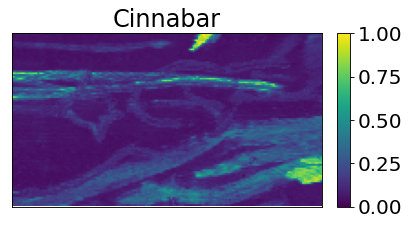

In [90]:
rcParams['font.size'] = 18

matrix_plot = criterion.copy()
matrix_plot /= matrix_plot.max(axis = 0, keepdims = True).max(axis = 1, keepdims = True)

for idx_phase, phase in enumerate(gm.phases):
    fig, ax  = subplots(figsize=(5,3))
    fig.set_dpi(80)
    title(phase.label)
    im = imshow(matrix_plot[..., idx_phase],
                vmin = 0, vmax = 1,
                origin = 'lower', cmap = 'viridis')
    colorbar(im, ax = ax, cax = ax.inset_axes([1.05, 0, 0.04, 1]))
    ax.set_yticks([])
    ax.set_xticks([])

    savefig(path_figures + 'primary - ' + phase.label + ' - criterion.png',
                bbox_inches = 'tight', dpi = 600)
show()

### Save TIF files

In [91]:
matrix_components_tiff = criterion.copy()
for p in range(matrix_components_tiff.shape[2]):
    matrix_components_tiff[..., p] = matrix_components_tiff[..., p] / matrix_components_tiff[..., p].max()
matrix_components_tiff = flip((matrix_components_tiff * 65535).astype('uint16'), axis = [0])

for idx_phase,phase in enumerate(gm.phases):
    img = Image.fromarray(matrix_components_tiff[..., idx_phase])
    img.save(path_results + 'primary - ' + phase.label + '.tiff')
    img.save(path_figures + 'primary - ' + phase.label + '.png')

# Save .cif files

In [92]:
for phase in experimental_phases:
    filename = path_database_exp + phase.label + '.cif'
    print(filename)
    phase.save_cif(filename)

databaseEXP/MunchMuseum/M491/Profilo/Hydrocerussite.cif
databaseEXP/MunchMuseum/M491/Profilo/Lazurite.cif
databaseEXP/MunchMuseum/M491/Profilo/Cinnabar.cif


# Explore one pixel with fitted tabulated phases

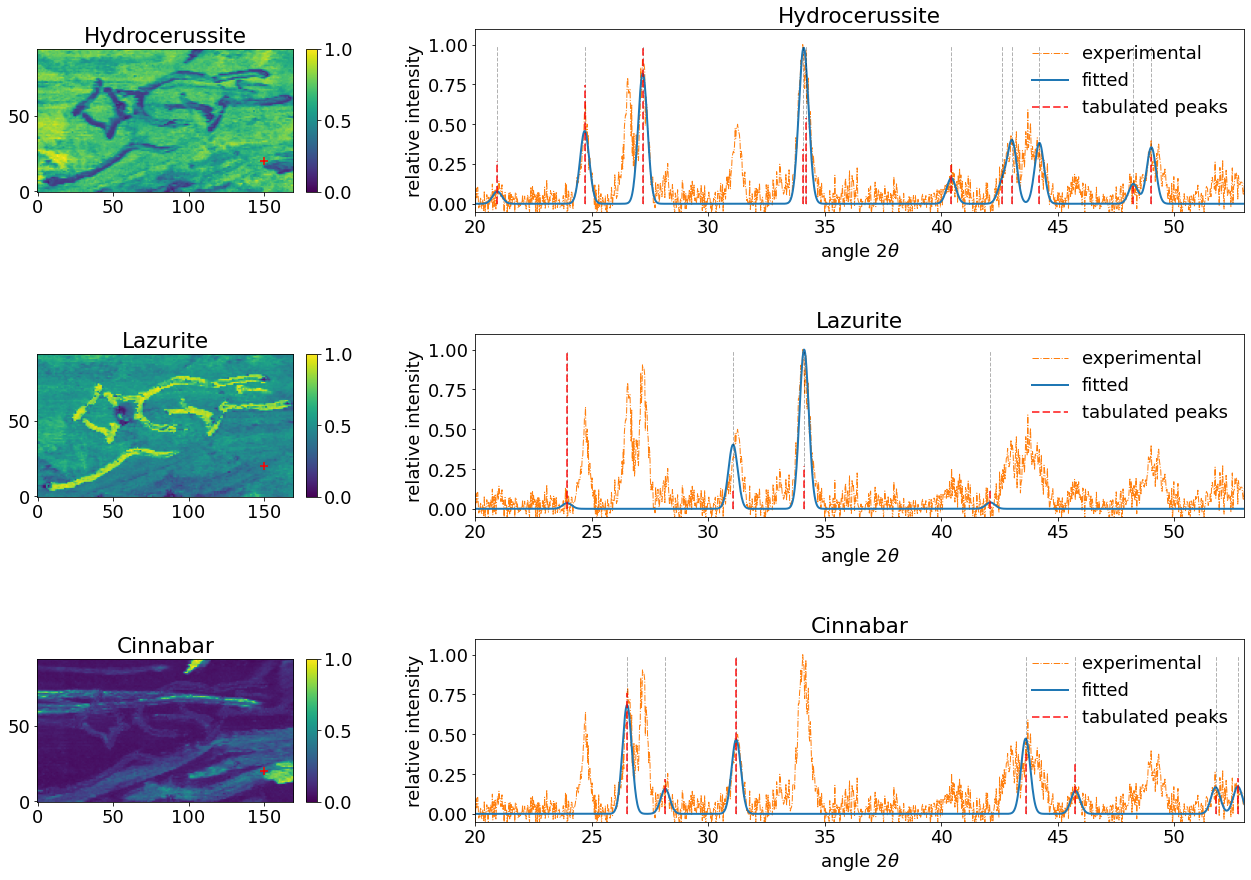

In [93]:
x, y = 150, 20

rcParams['font.size'] = 18

#matrix_plot = overlap_area.copy()
matrix_plot = criterion.copy()
matrix_plot /= matrix_plot.max(axis = 0, keepdims = True).max(axis = 1, keepdims = True)

fig, axs = subplots(len(gm.phases), 2, figsize = (18, 4*len(gm.phases)),
                   gridspec_kw = {'width_ratios': [1, 3]})
fig.tight_layout(h_pad = 5, w_pad = 7)

for i, phase in enumerate(gm.phases):

    g = gm.get_pixel(x, y)[i]

    if (len(gm.phases) > 1):
        ax = axs[i, 0]
    else:
        ax = axs[0]
    sca(ax)
    im = imshow(matrix_plot[..., i], vmin = 0)
    cbar = colorbar(im, ax = ax, cax = ax.inset_axes([1.05, 0, 0.04, 1]))
    #cbar.set_label('overlap')
    scatter(x, y, s = 50, c = 'red', marker = '+')
    ax.set_title(phase.label)

    if (len(experimental_phases) > 1):
        ax = axs[i, 1]
    else:
        ax = axs[1]
    sca(ax)
    #g.fit_cycle(gamma = True, steps = 128,a=True,s=True)
    g.plot_spectrum(c = 'tab:orange', ls = '-.', lw = 1, label = 'experimental')
    g.plot(c = 'tab:blue', ls = '-', lw = 2, label = 'fitted')
    g.phase.plot(color = 'k', lw = 1, lineheight = 1, alpha = 0.3, label = '')
    g.phase.plot(color = 'r', lw = 2, alpha = 0.7, label = 'tabulated peaks')
    ax.set_xlim(min_theta, max_theta)
    ax.set_ylim(-0.05, 1.1)
    ax.set_xlabel(r'angle $2\theta$')
    ax.set_ylabel(r'relative intensity')
    ax.set_title(phase.label)
    legend(frameon=False)

show()

# Explore one pixel with decomposition of experimental phases

In [94]:
x, y = 18, 80

cs = ChiSearch(experimental_phases, gm.get_pixel(x, y).spectrum, sigma = sigma, min_theta = min_theta,
    max_theta = max_theta, min_intensity = min_intensity, first_n_peaks = first_n_peaks)
cs.fit_cycle(steps = 8, chi = True)
#cs.search()

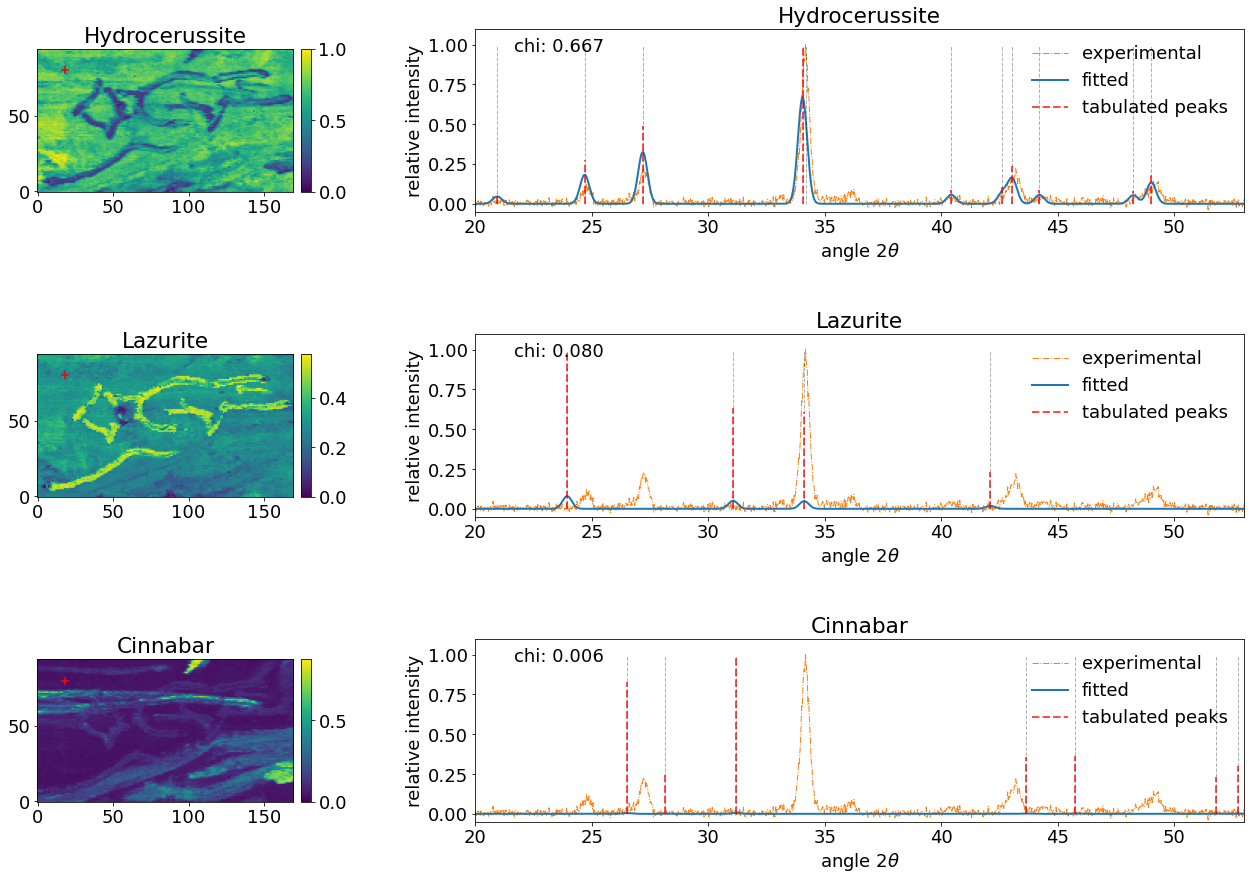

In [95]:
rcParams['font.size'] = 18
#matrix_plot = overlap_area.copy()
matrix_plot = criterion.copy()
matrix_plot /= matrix_plot.max()

fig, axs = subplots(len(cs), 2, figsize = (18, 4*len(cs)),
                   gridspec_kw = {'width_ratios': [1, 3]})
fig.tight_layout(h_pad = 5, w_pad = 7)

for i, g in enumerate(cs):
    if (len(cs) > 1):
        ax = axs[i, 0]
    else:
        ax = axs[0]
    sca(ax)
    im = imshow(matrix_plot[..., i], vmin = 0)
    cbar = colorbar(im, ax = ax, cax = ax.inset_axes([1.03, 0, 0.04, 1]))
    scatter(x, y, s = 50, c = 'red', marker = '+')
    ax.set_title(g.label)

    if (len(cs) > 1):
        ax = axs[i, 1]
    else:
        ax = axs[1]
    sca(ax)
    g.plot_spectrum(c = 'tab:orange', ls = '-.', lw = 1, label = 'experimental')
    plot(cs[0].theta, cs.z_decomposed()[:, i], c = 'tab:blue', ls = '-', lw = 2, label = 'fitted')
    g.phase.plot(color = 'k', lw = 1, lineheight = 1, alpha = 0.3, label = '')
    g.phase.plot(color = 'r', lw = 2, alpha = 0.7, label = 'tabulated peaks')
    ax.annotate(f'chi: {cs.chi.squeeze()[i]:.3f}', xy = (0.05, 0.95),
        xycoords = 'axes fraction', horizontalalignment = 'left', verticalalignment = 'top')
    ax.set_xlim(min_theta, max_theta)
    ax.set_ylim(-0.05, 1.1)
    ax.set_xlabel(r'angle $2\theta$')
    ax.set_ylabel(r'relative intensity')
    ax.set_title(g.label)
    legend(frameon=False)

show()

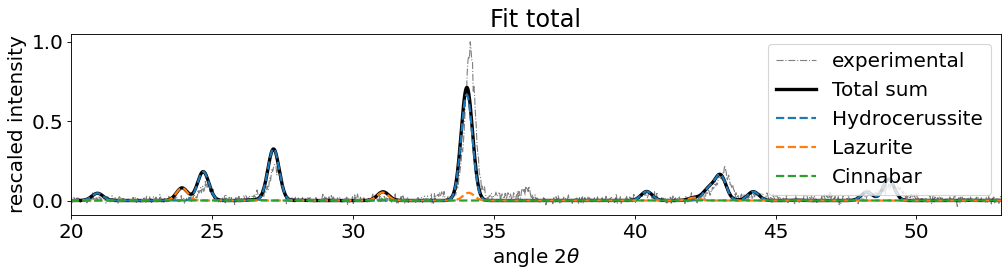

In [96]:
rcParams['font.size'] = 18

fig, ax = subplots(figsize = (15, 3))
sca(ax)
cs[0].plot_spectrum(c = 'grey', ls = '-.', lw = 1, label = 'experimental')
plot(cs[0].theta, cs.z(), c = 'black', ls = '-', lw = 3, label = 'Total sum')
for i_phase in range(len(cs)):
    plot(cs[0].theta, cs.z_decomposed()[:, i_phase],
         ls = '--', lw = 2, label = cs[i_phase].label)
ax.set_xlim(min_theta, max_theta)
ax.legend(loc = 'upper right')
ax.set_xlabel(r'angle $2\theta$')
ax.set_ylabel('rescaled intensity')
ax.set_title('Fit total')
fig.set_dpi(80)
show()

# Fit errrors

Plotting the histograms and maps of the error for each phase. 

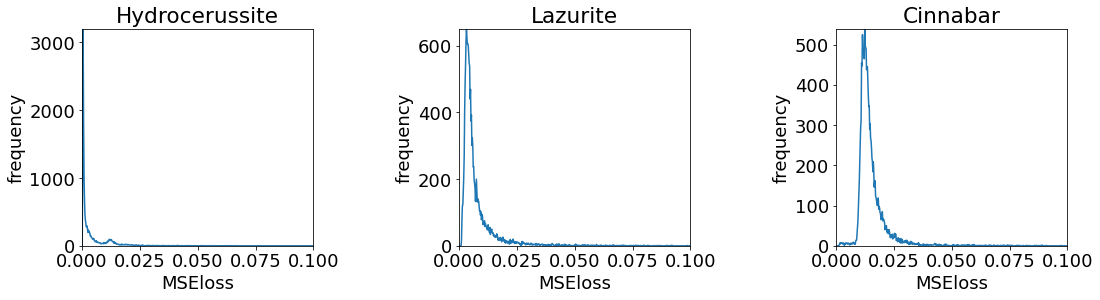

In [97]:
%matplotlib inline
n_of_columns = 3
rcParams['font.size'] = 18

n_of_pictures = len(gm.phases)
n_of_rows = n_of_pictures // n_of_columns
if (n_of_pictures % n_of_columns):
    n_of_rows += 1

fig, axs = subplots(n_of_rows, n_of_columns, figsize = (5 * n_of_columns, 4 * n_of_rows))
fig.tight_layout(h_pad = 5, w_pad = 5)
for i, phase in enumerate(gm.phases):
    i_row = i // n_of_columns
    i_column = i % n_of_columns
    if n_of_rows == 1:
        ax = axs[i_column]
    else:
        ax = axs[i_row, i_column]
    h, b = histogram(MSEloss[:, :, i], bins = 512,range = (0, 0.1))
    ax.plot(b[:-1], h)
    ax.set_xlim(0, b.max())
    ax.set_ylim(0, h.max())
    ax.set_xlabel('MSEloss')
    ax.set_ylabel('frequency')
    ax.set_title(phase.label)
show()

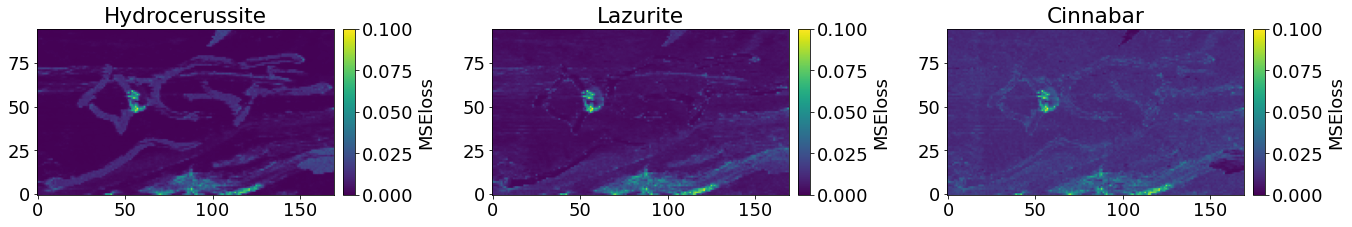

In [98]:
%matplotlib inline
n_of_columns = 3
rcParams['font.size'] = 18

n_of_pictures = len(gm.phases)
n_of_rows = n_of_pictures // n_of_columns
if (n_of_pictures % n_of_columns):
    n_of_rows += 1

fig, axs = subplots(n_of_rows, n_of_columns, figsize = (6 * n_of_columns, 4 * n_of_rows))
fig.tight_layout(h_pad = 0, w_pad = 6)
for i, phase in enumerate(gm.phases):
    i_row = i // n_of_columns
    i_column = i % n_of_columns
    if n_of_rows == 1:
        ax = axs[i_column]
    else:
        ax = axs[i_row, i_column]
    h, b = histogram(MSEloss[:, :, i], bins = 512,range = (0, 0.1))
    ax.set_title(phase.label)
    im = ax.imshow(MSEloss[:, :, i], vmin = 0, vmax = 0.1)
    cbar = colorbar(im, ax = ax, cax = ax.inset_axes([1.03, 0, 0.04, 1]))
    cbar.set_label('MSEloss')
show()

# Search for secondary phases

#### Smooth data

In [99]:
step = 2
method = 'mean'
#method = 'max'

data_smooth = data.generate_smooth(step, method)

Generating smooth data...
Removing background...
Done.
Done.


#### Check rescaling factor

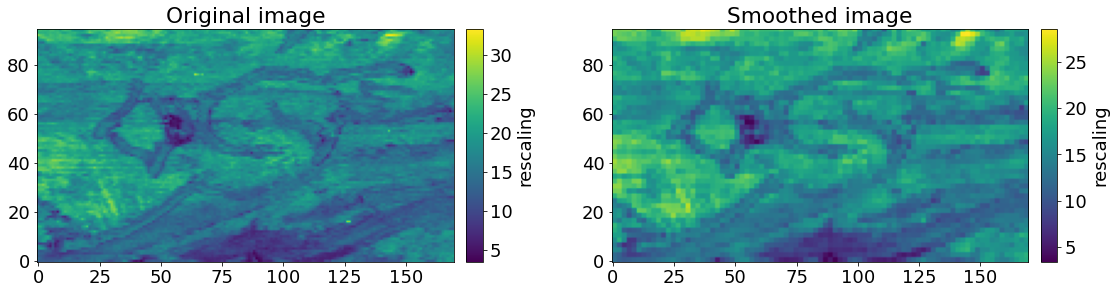

In [100]:
rcParams['font.size'] = 18

fig, axs = subplots(1, 2, figsize = (15, 6))
fig.tight_layout(w_pad = 6)

ax = axs[0]
im = ax.imshow(data.rescaling.squeeze()**0.5)
cbar = colorbar(im, ax = ax, cax = ax.inset_axes([1.03, 0, 0.04, 1]))
cbar.set_label('rescaling')
ax.set_title('Original image')

ax = axs[1]
im = ax.imshow(data_smooth.rescaling.squeeze()**0.5)
cbar = colorbar(im, ax = ax, cax = ax.inset_axes([1.03, 0, 0.04, 1]))
cbar.set_label('rescaling')
ax.set_title('Smoothed image')

show()

#### Refit primary phases on smoothed data

In [101]:
%%time
gm1 = GammaMap().from_data(data_smooth, phases_primary, sigma = sigma, min_theta = min_theta, max_theta = max_theta,
    min_intensity = min_intensity, first_n_peaks = first_n_peaks)

gm1 = gm1.search()

overlap_area_1 = gm1.overlap_area()

Using 8 CPUs
CPU times: user 13.3 s, sys: 1.62 s, total: 14.9 s
Wall time: 21.8 s


#### Fit secondary phases

In [102]:
%%time

#phases_secondary_blue = [prussian_blue, ultramarine_blue_dark, ultramarine_blue_very_dark, cobalt_blue_pale, cobalt_blue_dark, indigo, alum_k]
#phases_secondary_green = [viridian, phthalo_green_dark, verdigris, malachite]
#phases_secondary_yellow = [strontium_chromate, chrome_yellow, crocoite, Cd_S_orange, cobalt_yellow, goethite]
#phases_secondary_red = [sienna, Cd_S_red, hematite, madder_lake, alizarine]
#phases_secondary_black = [bone_black, caput_mortuum]
#phases_secondary_white = [zinc_white, barite]
#phases_secondary_violet = [cobalt_phosphate, manganese_violet, cobalt_arsenate]

phases_secondary = [Cd_S_orange, barite]

gm2 = GammaMap_Secondary().from_data(gm1, data_smooth, phases_secondary, sigma = sigma, min_theta = min_theta,
    max_theta = max_theta, min_intensity = min_intensity, first_n_peaks = first_n_peaks)

gm2 = gm2.fit_cycle(steps = 6, gamma = True)

overlap_area_compare_2 = gm2.overlap_area_difference()

Using 8 CPUs
CPU times: user 17.9 s, sys: 5.25 s, total: 23.1 s
Wall time: 25.1 s


#### Quantify phase presence

In [103]:
correction = data_smooth.rescaling**0.5
#correction = data_smooth.signal_background_ratio

criterion_1 = overlap_area_1 * correction
criterion_2 = overlap_area_compare_2 * correction

# Plots

### Primary phases

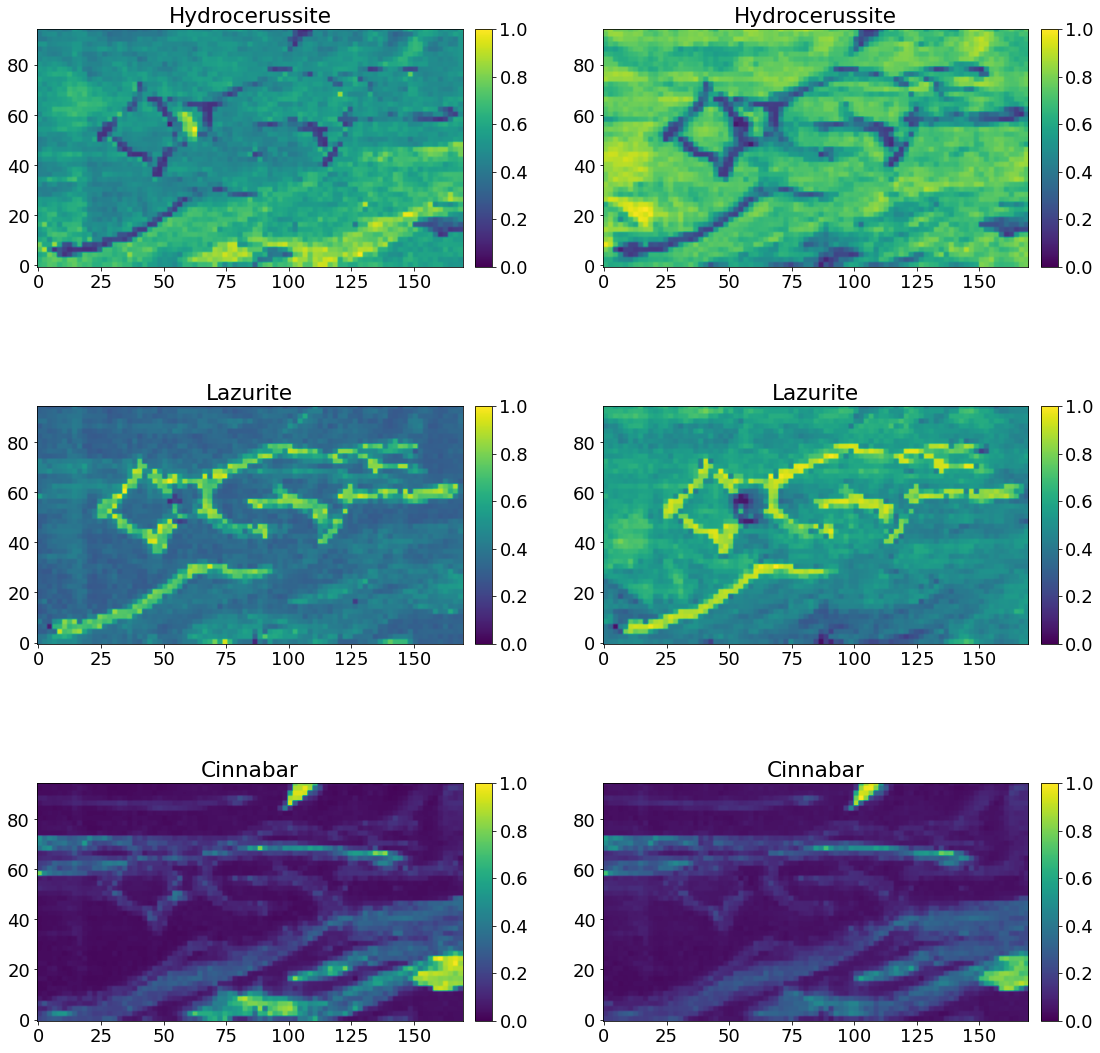

In [105]:
%matplotlib inline
rcParams['font.size'] = 18

fig, axs = subplots(len(gm1.phases), 2, figsize = (15, 5 * len(gm1.phases)))
fig.tight_layout(h_pad = 5, w_pad = 5)

for i, phase in enumerate(gm1.phases):
    ax = axs[i, 0]
    ax.set_title(phase.label)
    matrix_plot = overlap_area_1[..., i].copy()
    matrix_plot /= matrix_plot.max()
    im = ax.imshow(matrix_plot, vmin = 0)
    colorbar(im, ax = ax, cax = ax.inset_axes([1.03, 0, 0.04, 1]))

    ax = axs[i, 1]
    ax.set_title(phase.label)
    matrix_plot = criterion_1[..., i].copy()
    matrix_plot /= matrix_plot.max()
    im = ax.imshow(matrix_plot, vmin = 0)
    colorbar(im, ax = ax, cax = ax.inset_axes([1.03, 0, 0.04, 1]))

show()

### Secondary phases

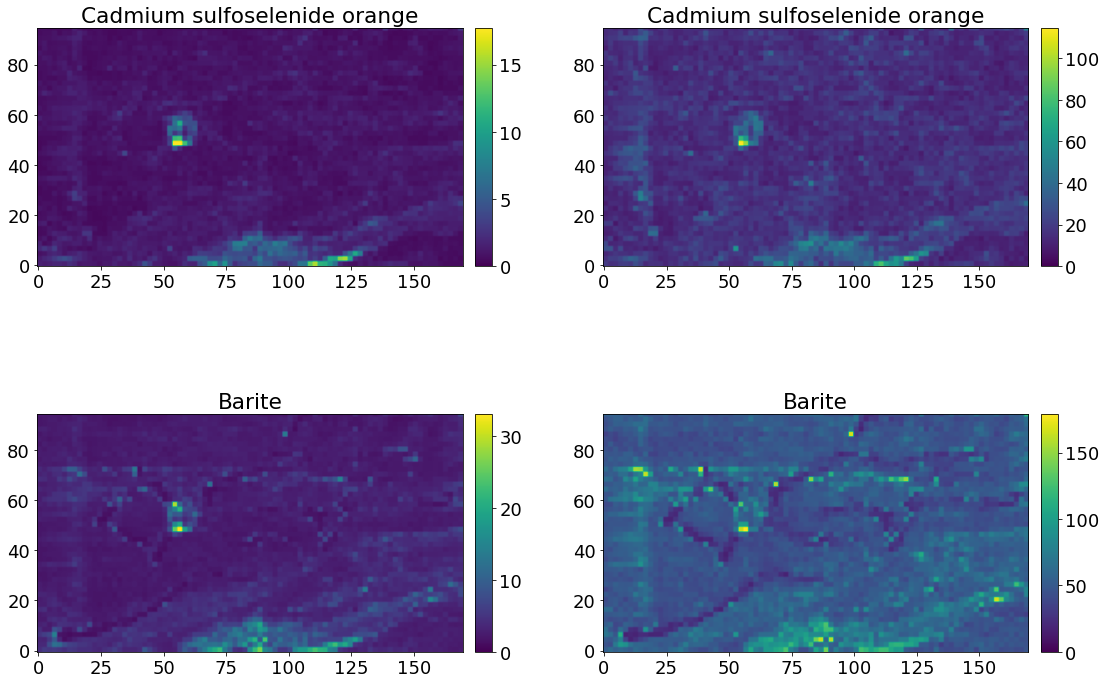

In [106]:
%matplotlib inline
rcParams['font.size'] = 18

fig, axs = subplots(len(gm2.phases), 2, figsize = (15, 5 * len(gm2.phases)))
fig.tight_layout(h_pad = 5, w_pad = 5)

for i, phase in enumerate(gm2.phases):
    if (len(gm2.phases) > 1):
        ax = axs[i, 0]
    else:
        ax = axs[0]
    ax.set_title(phase.label)
    matrix_plot = overlap_area_compare_2[..., i].copy()
    #matrix_plot /= matrix_plot.max()
    im = ax.imshow(matrix_plot, vmin = 0)
    colorbar(im, ax = ax, cax = ax.inset_axes([1.03, 0, 0.04, 1]))

    if (len(gm2.phases) > 1):
        ax = axs[i, 1]
    else:
        ax = axs[1]
    ax.set_title(phase.label)
    matrix_plot = criterion_2[..., i].copy()
    #matrix_plot /= matrix_plot.max()
    im = ax.imshow(matrix_plot, vmin = 0)
    colorbar(im, ax = ax, cax = ax.inset_axes([1.03, 0, 0.04, 1]))

show()

### Save maps of secondary phases as PNG and TIF

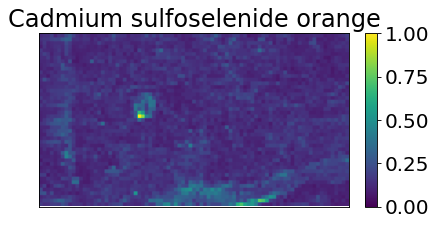

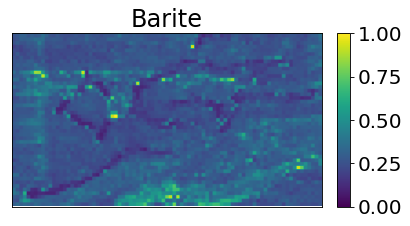

In [109]:
rcParams['font.size'] = 18

#matrix_plot = overlap_area_compare_2.copy()
matrix_plot = criterion_2.copy()

matrix_plot /= matrix_plot.max(axis = 0, keepdims = True).max(axis = 1, keepdims = True)
matrix_components_tiff = flip((matrix_plot * 65535).astype('uint16'), axis = [0])

for idx_phase, phase in enumerate(gm2.phases):
    fig, ax  = subplots(figsize=(5,3))
    ax.set_title(phase.label)
    im = imshow(matrix_plot[..., idx_phase], vmin = 0)
    colorbar(im, ax = ax, cax = ax.inset_axes([1.05, 0, 0.04, 1]))
    ax.set_yticks([])
    ax.set_xticks([])
    fig.set_dpi(80)
    savefig(path_figures + 'secondary - ' + phase.label + ' - criterion.png',
                bbox_inches = 'tight', dpi = 600)

    img = Image.fromarray(matrix_components_tiff[..., idx_phase])
    img.save(path_results + 'secondary - ' + phase.label + '.tiff')
    img.save(path_figures + 'secondary - ' + phase.label + '.png')

show()

# Verify overlap of secondary phases in chosen pixel

Primary phases: 0.8195 of experimental area
Secondary phases – Fraction of experimental area covered by each secondary phase but not by primary phases
Cadmium sulfoselenide orange:	0.0097
Barite:	0.0440


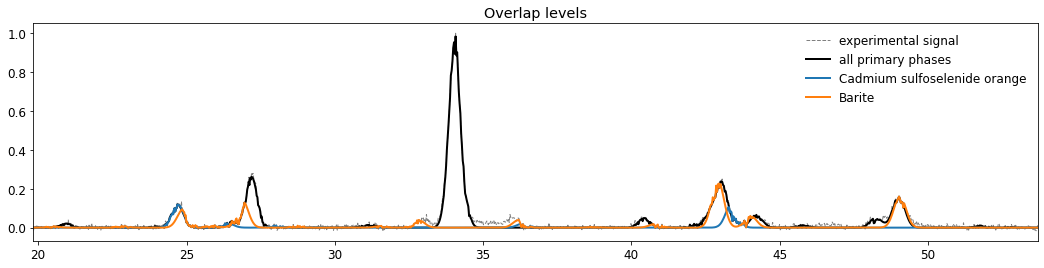

In [110]:
x, y = 20, 80
rcParams['font.size'] = 12

gs2 = gm2.get_pixel(x, y)

fig, ax = subplots(figsize = (18, 4))
theta = gs2.gammasearch_1[0].theta
ax.plot(theta, gs2.intensity, c = 'grey', ls = '--', lw = 1, label = 'experimental signal')
ax.plot(theta, gs2.gammasearch_1.overlap_total(), c = 'black', ls = '-', lw = 2, label = 'all primary phases')
print(f'Primary phases: {gs2.gammasearch_1.overlap_total_ratio():.4f} of experimental area')
print('Secondary phases – Fraction of experimental area covered by each secondary phase but not by primary phases')
for j in range(len(gs2)):
    ax.plot(theta, gs2.overlap()[j], ls = '-', lw = 2, label = gs2[j].phase.label)
    print(f'{gs2[j].label}:\t{gs2.overlap_area_compare()[j]:.4f}')

legend(frameon = False)
ax.set_xlim(theta[0], theta[-1])
ax.set_title('Overlap levels')
show()